# Linear regression

In this example, we will go through how to fit linear regression models in python. The dataset we will be using is the 2020 election voting data at the county level together with socio-economic data from Census Bureau's American Community Survey (ACS).

The problem of interest is: counties with what type of socio-economic profile will lean towards voting for the demotractic/republican party?

In [1]:
import pandas as pd
import geopandas as gpd

Read in the raw data

In [2]:
voting_url = "https://raw.githubusercontent.com/Ziqi-Li/GIS5122/spring-25/data/voting_2021.csv"
voting = pd.read_csv(voting_url)

In [3]:
voting.shape

(3108, 22)

In [4]:
voting.head()

,county_id,state,county,NAME,proj_X,proj_Y,total_pop,new_pct_dem,sex_ratio,pct_black,...,median_income,pct_65_over,pct_age_18_29,gini,pct_manuf,ln_pop_den,pct_3rd_party,turn_out,pct_fb,pct_uninsured
0,17051,17,51,"Fayette County, Illinois",597980.182064,1.796863e+06,21565,18.479911,113.6,4.7,...,46650,18.8,14.899142,0.4373,14.9,3.392748,1.740255,59.066079,1.3,8.2
1,17107,17,107,"Logan County, Illinois",559815.813333,1.920479e+06,29003,29.593095,97.2,6.9,...,57308,18.0,17.256835,0.4201,12.4,3.847163,2.392057,57.395734,1.6,4.5
2,17165,17,165,"Saline County, Illinois",650277.214895,1.660710e+06,23994,25.605949,96.9,2.6,...,44090,19.9,13.586730,0.4692,8.7,4.128731,1.572384,59.078533,1.0,4.2
3,17097,17,97,"Lake County, Illinois",654006.840698,2.174577e+06,701473,62.275888,99.8,6.8,...,89427,13.7,15.823132,0.4847,16.3,7.308582,1.960338,71.156446,18.7,6.8
4,17127,17,127,"Massac County, Illinois",640398.986258,1.599902e+06,14219,25.662005,89.5,5.8,...,47481,20.8,12.370772,0.4097,7.4,4.067788,1.335682,62.372974,1.0,5.4


Read in a county polygon

In [5]:
shp_url = "https://raw.githubusercontent.com/Ziqi-Li/GIS5122/spring-25/data/County_shp_2018/County_shp_2018.shp"
shp = gpd.read_file(shp_url)

<Axes: >

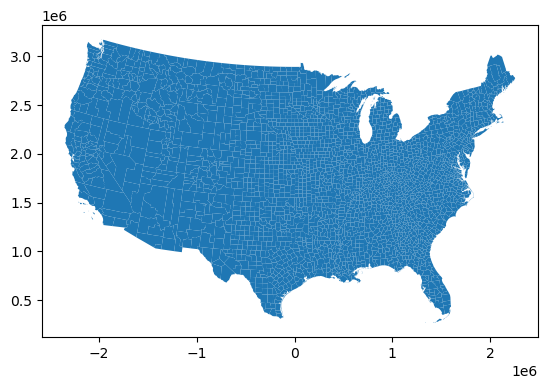

In [6]:
shp.plot()

In [7]:
shp.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geoid_int,geometry
0,39,071,01074048,0500000US39071,39071,Highland,06,1432479992,12194983,39071,"POLYGON ((1037181.007 1847418.019, 1034790.811..."
1,06,003,01675840,0500000US06003,06003,Alpine,06,1912292630,12557304,6003,"POLYGON ((-2057214.391 1981928.249, -2051788.3..."
2,12,033,00295737,0500000US12033,12033,Escambia,06,1701544502,563927612,12033,"POLYGON ((797106.710 901987.747, 797133.592 90..."
3,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,17101,"POLYGON ((697325.783 1756964.285, 694889.230 1..."
4,28,153,00695797,0500000US28153,28153,Wayne,06,2099745573,7255476,28153,"POLYGON ((664815.315 992438.494, 664464.412 99..."


Merge two DataFrames using the common key (geoid and county_id).

In [8]:
shp_df = shp.merge(voting,left_on="geoid_int",right_on="county_id")

Make a map on how people voted. A pretty familar blue-red landscape.

<Axes: >

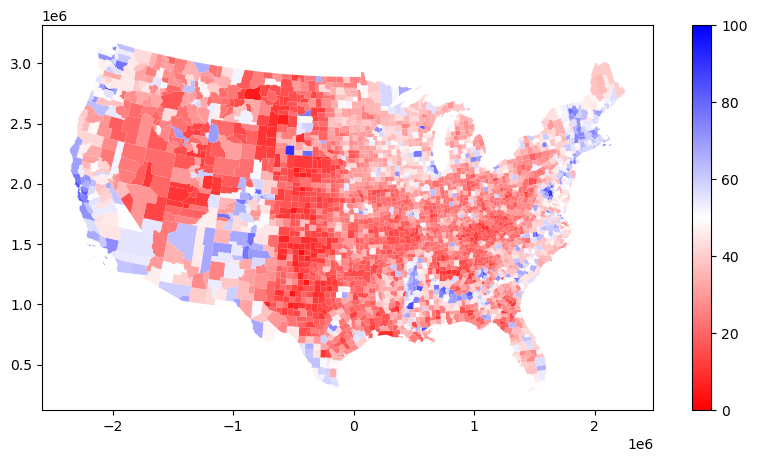

In [9]:
shp_df.plot(column="new_pct_dem",cmap="bwr_r",vmin=0,vmax=100,legend=True,figsize=(10,5))

## Linear Regression

Linear regression models will be estimated using the `statsmodels` library.

In [10]:
import statsmodels.formula.api as smf

In [11]:
shp_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME_x',
       'LSAD', 'ALAND', 'AWATER', 'geoid_int', 'geometry', 'county_id',
       'state', 'county', 'NAME_y', 'proj_X', 'proj_Y', 'total_pop',
       'new_pct_dem', 'sex_ratio', 'pct_black', 'pct_hisp', 'pct_bach',
       'median_income', 'pct_65_over', 'pct_age_18_29', 'gini', 'pct_manuf',
       'ln_pop_den', 'pct_3rd_party', 'turn_out', 'pct_fb', 'pct_uninsured'],
      dtype='object')

In [12]:
import matplotlib.pyplot as plt

Make a simple scatterplot, we can see a bit of positive correlation between the two variables.

Text(0, 0.5, '% of people voted for the democratic party (pct_dem)')

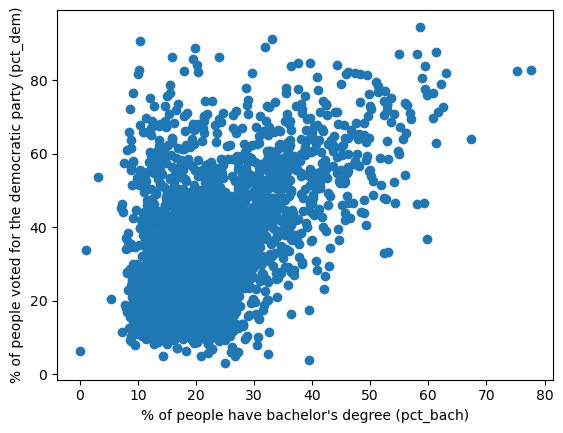

In [13]:
plt.scatter(shp_df.pct_bach, shp_df.new_pct_dem)
plt.xlabel("% of people have bachelor's degree (pct_bach)")
plt.ylabel("% of people voted for the democratic party (pct_dem)")

Pearson correlation coefficient indicates a moderate level of correlation with a small p-value.

In [14]:
from scipy.stats import pearsonr
pearsonr(shp_df.pct_bach, shp_df.new_pct_dem)

PearsonRResult(statistic=0.533176728506253, pvalue=7.032775736232285e-228)

### Now lets specify a simple model with 1 predictor:
**Model_1:** new_pct_dem ~ 1 + pct_bach

**new_pct_dem:** outcome variable, % of people vote for the democratic party

**pct_bach:** predictor variable, % of people have bachelor's degree

**1:** is to add the intercept, this is **often** needed


In [15]:
model_1 = smf.ols(formula='new_pct_dem ~ 1 + pct_bach', data=shp_df).fit()

In [16]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            new_pct_dem   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     1234.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          7.03e-228
Time:                        09:53:47   Log-Likelihood:                -12560.
No. Observations:                3108   AIC:                         2.512e+04
Df Residuals:                    3106   BIC:                         2.514e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.9652      0.618     22.615      0.000      12.754      15.176
pct_bach       0.9055      0.026     35.124      0.000       0.855       0.956
==============================================================================
Omnibus:                      376.503   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              603.255
Skew:                           0.845   Prob(JB):                    1.01e-131
Kurtosis:                       4.342   Cond. No.                         60.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the `coef` column in the above data, we can get the the regression function:

pct_dem = 13.9652 + 0.9055*pct_bach

**Interpretations:**

1. % of Bach has a positive correlation with % DEM (indicated by a positive coefficient).
2. Increase 1% Bach will increase 0.9055% people vote for DEM.
3. The p-values for both intercept and % Bach are very small (<0.05) indicting both coefficients/found relationships are **statsitically** significant.
4. The R2 value = 0.284 indicating some level of explanatory power of this model. Rememmber that 0<=R2<=1.

In [17]:
import numpy as np
np.sqrt(0.284)

0.532916503778969

The square root of R2 is also the pearson's correlation coefficient.

### Now lets specify a more complicated model with 3 predictors:
**Model_2:** new_pct_dem ~ 1 + pct_bach + median_income + ln_pop_den

**new_pct_dem:** outcome variable, % of people vote for the democratic party

**pct_bach:** predictor variable, % of people have bachelor's degree

**median_income:** predictor variable, median income

**ln_pop_den:** predictor variable, log scale of population density

**1:** is to add the intercept, this is often needed


In [18]:
model_2 = smf.ols(formula='new_pct_dem ~ 1 + pct_bach + median_income + ln_pop_den', data=shp_df).fit()

In [19]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            new_pct_dem   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     789.2
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:53:47   Log-Likelihood:                -12199.
No. Observations:                3108   AIC:                         2.441e+04
Df Residuals:                    3104   BIC:                         2.443e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.3905      0.898     19.361      0.000      15.629      19.152
pct_bach          0.9890      0.034     29.145      0.000       0.923       1.056
median_income    -0.0004   2.23e-05    -15.804      0.000      -0.000      -0.000
ln_pop_den        3.5657      0.142     25.074      0.000       3.287       3.845
==============================================================================
Omnibus:                      483.110   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.802
Skew:                           1.002   Prob(JB):                    5.90e-184
Kurtosis:                       4.580   Cond. No.                     2.25e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This gives us the new regression function:

pct_dem = 17.3905 + 0.9890 * pct_bach + -0.0004 *median_income + 3.5657 * ln_pop_den

**Interpretations:**

1. % of Bach, population density have a positive correlation with % DEM.
2. Median income has a negative correlation with % DEM.
3. Increasing 1% Bach will increase 0.9890% people vote for DEM, while holding other variables constant
4. Increasing 1 dollar median income will decrease 0.0004% people vote for DEM, while holding other variables constant. This also translates to increasing $10,000 will decrease 4% in y.
3. The p-values for all variables are very small (<0.05) indicting all coefficients/found relationships are **statsitically** significant.
4. The R2 value = 0.433 indicating a better explanatory power of this model compared to model 1.

## Diagnostic Plots
What are the four assumptions of linear regression? Hint: LINE

A residual vs. fitted plot

In [20]:
#get the predicted value
pred = model_2.fittedvalues

#get the residual
resid = model_2.resid

Any obvisous issue you can see? We are aiming for points scattered around 0 line.

Text(0.5, 1.0, 'Model 2')

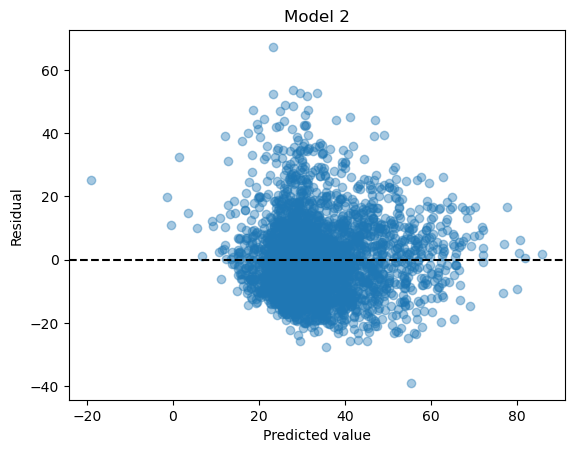

In [21]:
plt.scatter(pred, resid,alpha=0.4)

plt.axhline(y = 0.0, color = 'black', linestyle = '--')

plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.title("Model 2")

Examine residual normality. Is it skewed?

(array([1.000e+00, 9.300e+01, 8.650e+02, 1.137e+03, 6.410e+02, 2.330e+02,
        9.500e+01, 3.200e+01, 1.000e+01, 1.000e+00]),
 array([-38.91209715, -28.29712822, -17.6821593 ,  -7.06719038,
          3.54777854,  14.16274746,  24.77771638,  35.3926853 ,
         46.00765422,  56.62262314,  67.23759207]),
 <BarContainer object of 10 artists>)

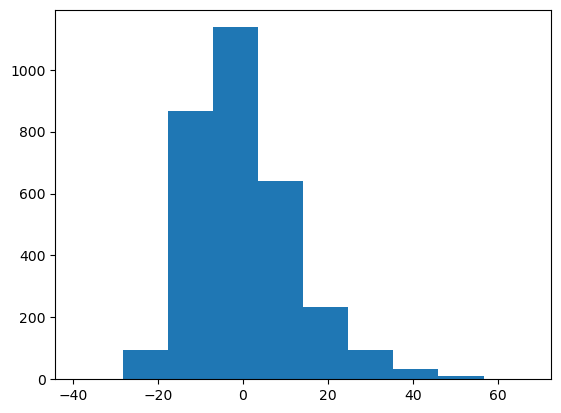

In [22]:
plt.hist(resid)

Then let's draw a Q-Q plot. The expectation is that if all the blue dots (residuals) should lie on that straight line which represents a perfect normal distribution. It is  obvious that the residuals are not  normal.

((array([-3.51125824, -3.26814139, -3.13373139, ...,  3.13373139,
          3.26814139,  3.51125824]),
  array([-38.91209715, -27.53724546, -25.76653482, ...,  52.7401659 ,
          53.71192504,  67.23759207])),
 (11.948687014006419, -1.0300872371263392e-11, 0.9739250994350437))

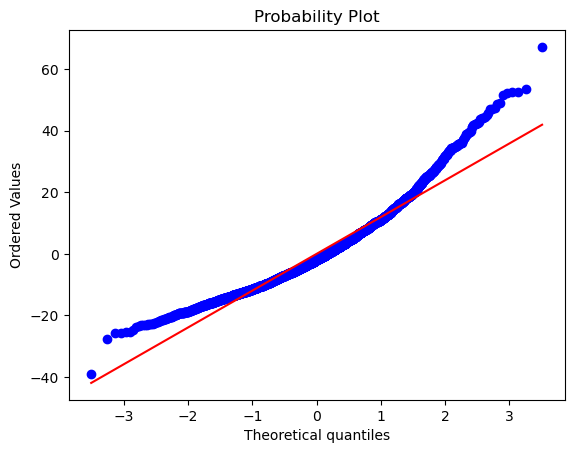

In [23]:
import scipy.stats as stats

stats.probplot(resid, dist="norm", plot=plt)

# A full model

Let's add some more variables into the model

In [24]:
shp_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME_x',
       'LSAD', 'ALAND', 'AWATER', 'geoid_int', 'geometry', 'county_id',
       'state', 'county', 'NAME_y', 'proj_X', 'proj_Y', 'total_pop',
       'new_pct_dem', 'sex_ratio', 'pct_black', 'pct_hisp', 'pct_bach',
       'median_income', 'pct_65_over', 'pct_age_18_29', 'gini', 'pct_manuf',
       'ln_pop_den', 'pct_3rd_party', 'turn_out', 'pct_fb', 'pct_uninsured'],
      dtype='object')

In [25]:
formula = 'new_pct_dem ~ 1 + sex_ratio + pct_black + pct_hisp + pct_bach + \
            median_income + pct_65_over + pct_age_18_29 + gini + pct_manuf + \
            ln_pop_den + pct_3rd_party + turn_out + pct_fb + pct_uninsured'

model_3 = smf.ols(formula=formula, data=shp_df).fit()

In [26]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            new_pct_dem   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     455.1
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:53:48   Log-Likelihood:                -11342.
No. Observations:                3108   AIC:                         2.271e+04
Df Residuals:                    3093   BIC:                         2.280e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -25.5366      4.843     -5.272      0.000     -35.033     -16.040
sex_ratio         0.0376      0.017      2.162      0.031       0.004       0.072
pct_black         0.5523      0.014     39.052      0.000       0.525       0.580
pct_hisp          0.3120      0.020     15.745      0.000       0.273       0.351
pct_bach          0.6819      0.039     17.542      0.000       0.606       0.758
median_income    -0.0002   2.58e-05     -8.428      0.000      -0.000      -0.000
pct_65_over       0.1804      0.058      3.103      0.002       0.066       0.294
pct_age_18_29     0.1371      0.067      2.036      0.042       0.005       0.269
gini             18.0909      6.040      2.995      0.003       6.249      29.933
pct_manuf         0.0487      0.030      1.646      0.100      -0.009       0.107
ln_pop_den        2.6681      0.154     17.328      0.000       2.366       2.970
pct_3rd_party     4.3480      0.234     18.582      0.000       3.889       4.807
turn_out          0.2263      0.026      8.750      0.000       0.176       0.277
pct_fb            0.1392      0.051      2.707      0.007       0.038       0.240
pct_uninsured    -0.3402      0.044     -7.683      0.000      -0.427      -0.253
==============================================================================
Omnibus:                     1000.163   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8501.905
Skew:                           1.283   Prob(JB):                         0.00
Kurtosis:                      10.686   Cond. No.                     2.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model is more improved with an R2 of **0.673**.

In [27]:
#get the predicted value
pred_3 = model_3.fittedvalues

#get the residual
resid_3 = model_3.resid

Let's remake these diagnostic plots, now they look much better, though there are some outliers towards the left side (being under-estimated)!

Text(0.5, 1.0, 'Model 3')

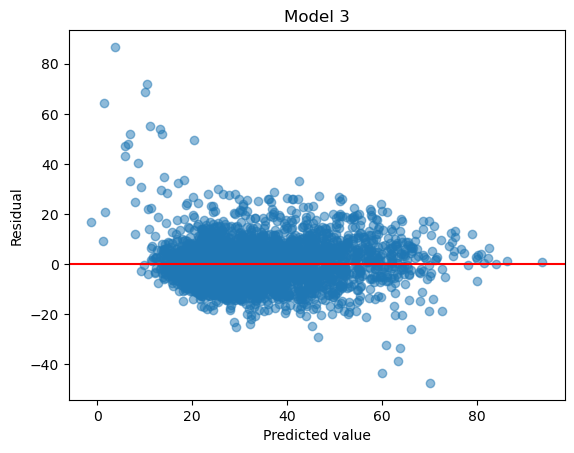

In [28]:
plt.scatter(pred_3, resid_3,alpha=0.5)

plt.axhline(y = 0.0, color = 'r', linestyle = '-')

plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.title("Model 3")

(array([3.000e+00, 1.200e+01, 5.960e+02, 1.866e+03, 5.510e+02, 6.300e+01,
        6.000e+00, 7.000e+00, 3.000e+00, 1.000e+00]),
 array([-47.50438204, -34.08283911, -20.66129618,  -7.23975325,
          6.18178968,  19.60333261,  33.02487554,  46.44641847,
         59.8679614 ,  73.28950433,  86.71104726]),
 <BarContainer object of 10 artists>)

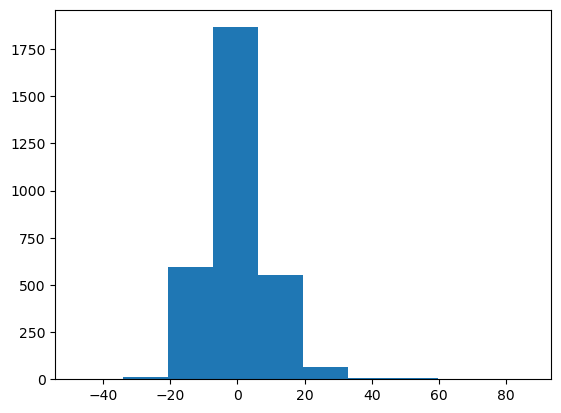

In [29]:
plt.hist(resid_3)

The QQ plot indicates that other than some extreme values, most dots are on the straight line.

((array([-3.51125824, -3.26814139, -3.13373139, ...,  3.13373139,
          3.26814139,  3.51125824]),
  array([-47.50438204, -43.62464376, -38.82786172, ...,  68.71420089,
          72.06270506,  86.71104726])),
 (8.974562038717119, -8.036338612680667e-13, 0.9638037012086432))

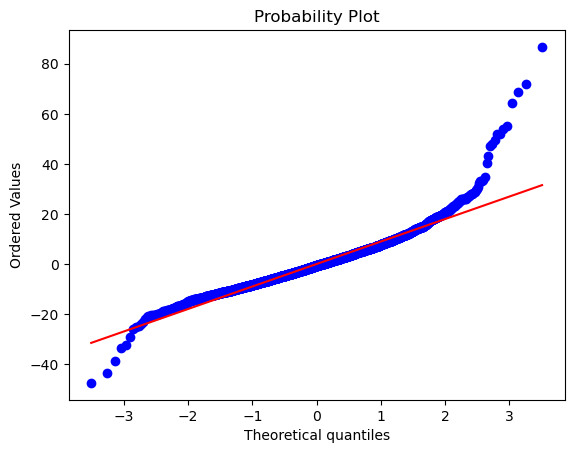

In [30]:
import scipy.stats as stats
stats.probplot(resid_3, dist="norm", plot=plt)